# Invoking a LADSPA plugin from Python

After installing the LADSPA sdk, you can likely enumerate available plugins by typing <pre>listplugins</pre> at a terminal.

The LADSPA v1 header is useful to keep open while reading:

https://www.ladspa.org/ladspa_sdk/ladspa.h.txt

Here we load a digital delay line included with the SDK:

In [1]:
import ctypes
import numpy as np

# Declare interfaces to the structures and functions we'll call.

# typedefs and constants
LADSPA_Data = ctypes.c_float
LADSPA_Properties = ctypes.c_int
LADSPA_Handle = ctypes.c_void_p

LADSPA_PortDescriptor = ctypes.c_int
kLADSPA_PORT_INPUT   = 0x1
kLADSPA_PORT_OUTPUT = 0x2

LADSPA_PortRangeHintDescriptor = ctypes.c_int;
# hint constants omitted for brevity; reference the .h file.

class LADSPA_PortRangeHint(ctypes.Structure):
    pass
LADSPA_PortRangeHint._fields = [
    ("HintDescriptor", LADSPA_PortRangeHintDescriptor),
    ("LowerBound", LADSPA_Data),
    ("UpperBound", LADSPA_Data)
]

class LADSPA_Descriptor(ctypes.Structure):
    pass
LADSPA_Descriptor._fields_= [
    ("UniqueID", ctypes.c_long),
    ("Label", ctypes.c_char_p),
    ("Properties", LADSPA_Properties),
    ("Name", ctypes.c_char_p),
    ("Maker", ctypes.c_char_p),
    ("Copyright", ctypes.c_char_p),
    ("PortCount", ctypes.c_ulong),
    ("PortDescriptors", ctypes.POINTER(LADSPA_PortDescriptor)),
    ("PortNames", ctypes.POINTER(ctypes.c_char_p)),
    ("PortRangeHints", ctypes.POINTER(LADSPA_PortRangeHint)),
    ("ImplementationData", ctypes.c_void_p),
    
    # Interface is via function pointers in the struct.
    ("instantiate", ctypes.CFUNCTYPE(LADSPA_Handle, ctypes.POINTER(LADSPA_Descriptor), ctypes.c_ulong)),
    ("connect_port", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle, ctypes.c_ulong)),
    ("activate", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle)),
    ("run", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle)),
    ("run_adding", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle, ctypes.c_ulong)),
    ("run_adding_gain", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle, LADSPA_Data)),
    ("deactivate", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle)),
    ("cleanup", ctypes.CFUNCTYPE(ctypes.c_int, LADSPA_Handle))
]

# The actual library has only one function.
# The argument, |index|, can choose one of N plugins in the library.
# Indices beyond that range are NULL.
def loadPlugin(name = '/usr/lib/ladspa/delay.so', index=0):
    plugin = ctypes.CDLL(name)
    plugin.ladspa_descriptor.argtypes = [ctypes.c_ulong]
    plugin.ladspa_descriptor.restype = ctypes.POINTER(LADSPA_Descriptor)
    return plugin.ladspa_descriptor(index)


## Load a plugin and get metadata

In [2]:
plugHandle = 0
plugPtr = loadPlugin()
plugInst = plugPtr[0] # dereference pointer
print("Plugin: %s by: %s, (c) %s" % (plugInst.Name, plugInst.Maker, plugInst.Copyright))
print("ports:")
for i in range(plugInst.PortCount):
    print("%s - %s" % (plugInst.PortNames[i], plugInst.PortDescriptors[i]))

Plugin: b'Simple Delay Line' by: b'Richard Furse (LADSPA example plugins)', (c) b'None'
ports:
b'Delay (Seconds)' - 5
b'Dry/Wet Balance' - 5
b'Input' - 9
b'Output' - 10


## Create a plugin instance and run some audio through it

In [52]:
if plugHandle == 0:
  plugHandle = plugInst.instantiate(plugPtr, 44100)

# Connect ports
AUDIO_BUFFER_LEN = 512
control0 = [1.0]  # Delay(seconds), default. Should obtain from LADSPA hint.
control1 = [0.5]  # wet/dry mix, default

# Create actual control port buffers.
b0 = (ctypes.c_float * 1)(*control0)
b1 = (ctypes.c_float * 1)(*control1)
inbuf_proto = [0.0]*AUDIO_BUFFER_LEN
outbuf_proto = [0.0]*AUDIO_BUFFER_LEN
bufIn = (ctypes.c_float * AUDIO_BUFFER_LEN)(*inbuf_proto)
bufOut = (ctypes.c_float * AUDIO_BUFFER_LEN)(*outbuf_proto)

buffer2 = ctypes.create_string_buffer(8 * AUDIO_BUFFER_LEN)
buffer3 = ctypes.create_string_buffer(8 * AUDIO_BUFFER_LEN)

plugInst.connect_port(plugHandle, 0, b0)
plugInst.connect_port(plugHandle, 1, b1)
plugInst.connect_port(plugHandle, 2, bufIn)
plugInst.connect_port(plugHandle, 3, bufOut)
plugInst.activate(plugHandle)

# Delay in seconds to 0.01s (441 samples at 44.1kHz)
inBuf = [0.0] * AUDIO_BUFFER_LEN
outBuf = [0.0] * AUDIO_BUFFER_LEN
# set up a simple input signal
for i in range(100):
    inBuf[i] = 0.2
inBuf[10] = 1.0
inBuf[12] = -0.5
inBuf[14] = 0.25

inBuf_copy = np.copy(inBuf)  # for future comparison, if needed

In [53]:
inBuf_ptr = ctypes.cast(buffer2.raw, ctypes.POINTER(ctypes.c_float))
outBuf_ptr = ctypes.cast(buffer3.raw, ctypes.POINTER(ctypes.c_float))

In [54]:
[inBuf_ptr, outBuf_ptr]

In [61]:
for i in range(AUDIO_BUFFER_LEN):
    # inBuf_ptr[i] = ctypes.c_float(inBuf[i])
    bufIn[i] = ctypes.c_float(inBuf[i])

outputBuf = []
for i in range(100):
    for i in range(AUDIO_BUFFER_LEN):
        bufOut[i] = 0
    plugInst.run(plugHandle, AUDIO_BUFFER_LEN)
    # Copy out data back out.
    # Again could likely just create an alias and cast instead.
    for i in range(AUDIO_BUFFER_LEN):
        outBuf[i] = bufOut[i]
    outputBuf.extend(outBuf)
    # zero out input
    for i in range(AUDIO_BUFFER_LEN):
        bufIn[i] = 0

# Do we have a half-amplitude copy of our signal after 1s?
window_start = int(1 * 44100)
outputBuf[window_start-2:window_start+15]

[0.0,
 0.0,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.10000000149011612,
 0.5,
 0.10000000149011612,
 -0.25,
 0.10000000149011612,
 0.125]

## Data is available for plotting:

In [57]:
import numpy as np
import matplotlib.pyplot as plt

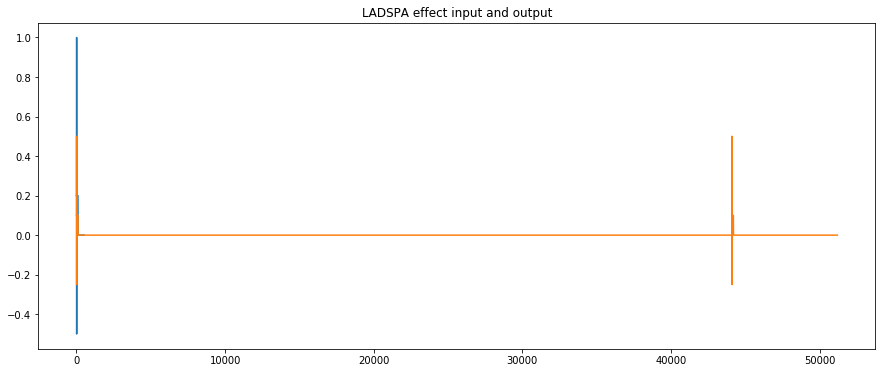

In [58]:
fig = plt.figure(figsize=(15,6))
plt.title('LADSPA effect input and output')
plt.plot(inBuf)
plt.plot(outputBuf)